Tema: ***Recomendação de filmes com base no histórico de um usuário***

<br/>David Aaron Medeiro
<br/>Raissa Barbosa dos Santos

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# Fonte de dados: https://www.kaggle.com/datasets/grouplens/movielens-20m-dataset?resource=download&select=movie.csv

# Lendo os datasets
df_movie = pd.read_csv('/content/drive/MyDrive/IA/Trabalho Final/movie.csv')
df_movie_rating = pd.read_csv('/content/drive/MyDrive/IA/Trabalho Final/rating.csv')

df_movie_rating = df_movie_rating.drop(['timestamp'], axis=1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df_movie.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
df_movie_rating.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,userId,movieId,rating
0,1,2,3.5
1,1,29,3.5
2,1,32,3.5
3,1,47,3.5
4,1,50,3.5


A base utilizada é a que pode ser encontrada em https://www.kaggle.com/datasets/grouplens/movielens-20m-dataset?resource=download&select=movie.csv, e as tabelas que usamos foram *rating.csv* e *movie.csv*.
<br/><br/>
Para iniciar o desenvolvimento, os dados foram vistos de algumas formas diferentes para que pudéssemos entender qual seria a melhor abordagem com ele. Como por conta de que uma das tabelas é bastante grande, a tabela de *rating.csv*, possuindo mais de 20mi de linhas, alguns filtros iniciais foram feitos.

In [ ]:
print("Valores nulos em movie.csv:")
print(df_movie.isnull().sum())

print("\nValores nulos em rating.csv:")
print(df_movie_rating.isnull().sum())

Valores nulos em movie.csv:
movieId    0
title      0
genres     0
dtype: int64

Valores nulos em rating.csv:
userId     0
movieId    0
rating     0
dtype: int64


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
print(df_movie.dtypes)

movieId     int64
title      object
genres     object
dtype: object


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
# Número de avaliações por userId e rating
user_ratings_distribution = df_movie_rating.groupby(['userId', 'rating']).size().unstack(fill_value=0)

# Total de avaliações por usuário
user_ratings_count = df_movie_rating.groupby('userId').size()

top_10_users = user_ratings_count.nlargest(10).index
top_10_user_ratings = user_ratings_distribution.loc[top_10_users]

# Top 10 usuários com mais avaliações feitas
print(top_10_user_ratings)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


rating   0.5   1.0  1.5   2.0   2.5   3.0   3.5   4.0  4.5  5.0
userId                                                         
118205     1     0    0   484   528  4073  1791  2283   67   27
8405       0    73  382   900  1131  1442  1084  1531  534  438
82418     16   193   81   454   302  1107   838  1529  258  868
121535    83   296  270   890   935  1400   707   731  161   47
125794     1     4    4    98   334  1017   856  2115  392  670
74142   1673  1714  112   584   163   599   125   317    8  152
34576      4    29  135   475   916  1747  1599   424   23    4
131904     6    23   51   185   415  1796  2115   629  100   10
83090      0   157    0  3164     0  1488     0   318    0   42
59477     95   181  378  1249  1442  1054   395   149   36    9


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


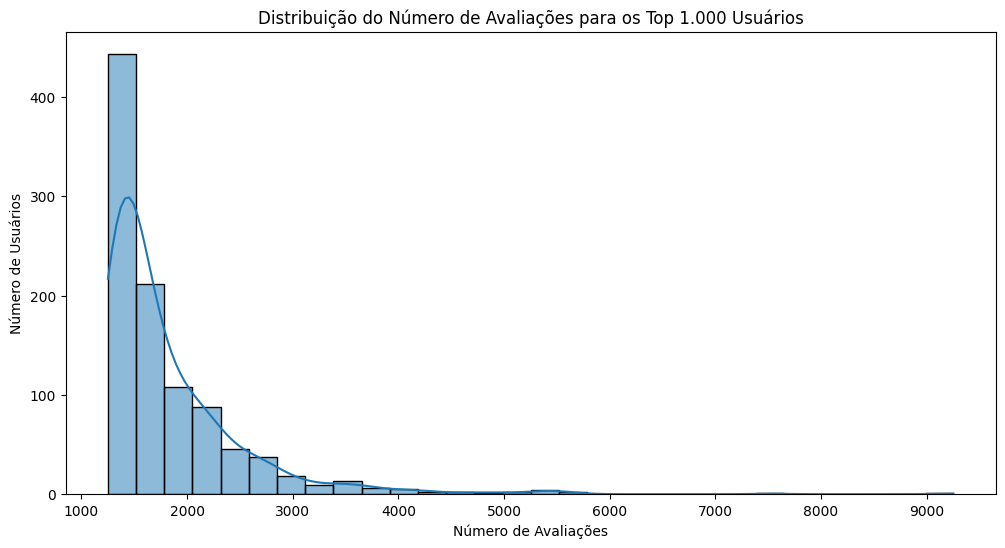

In [ ]:
# Número de avaliações por userId

user_ratings_count = df_movie_rating['userId'].value_counts().reset_index()
user_ratings_count.columns = ['userId', 'num_ratings']

user_ratings_count_sorted = user_ratings_count.sort_values(by='num_ratings', ascending=False)
top_1000_users = user_ratings_count_sorted.head(1000)


plt.figure(figsize=(12, 6))
sns.histplot(top_1000_users['num_ratings'], bins=30, kde=True)

plt.title('Distribuição do Número de Avaliações para os Top 1.000 Usuários')
plt.xlabel('Número de Avaliações')
plt.ylabel('Número de Usuários')

# Top 1000 com mais avaliações
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


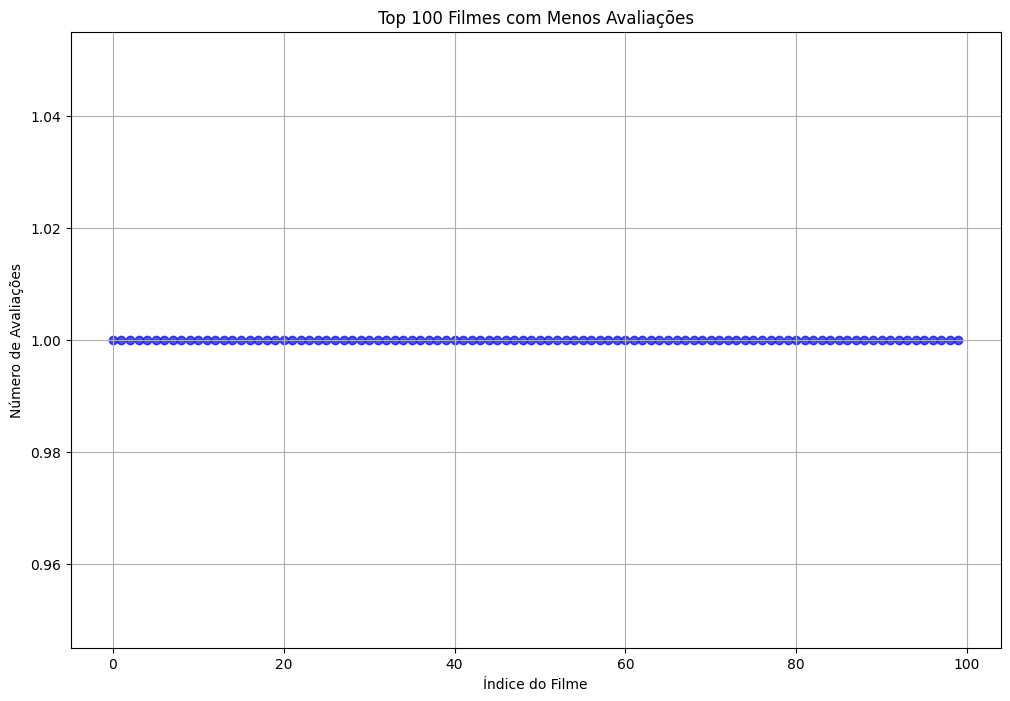

In [15]:
# Top 100 filmes com menos avaliações

film_review_count = df_movie_rating['movieId'].value_counts().reset_index()
film_review_count.columns = ['movieId', 'num_reviews']

least_reviewed = film_review_count.nsmallest(100, 'num_reviews')


plt.figure(figsize=(12, 8))
plt.scatter(range(len(least_reviewed)), least_reviewed['num_reviews'], c='blue', alpha=0.7)
plt.xlabel('Índice do Filme')
plt.ylabel('Número de Avaliações')
plt.title('Top 100 Filmes com Menos Avaliações')
plt.grid(True)
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


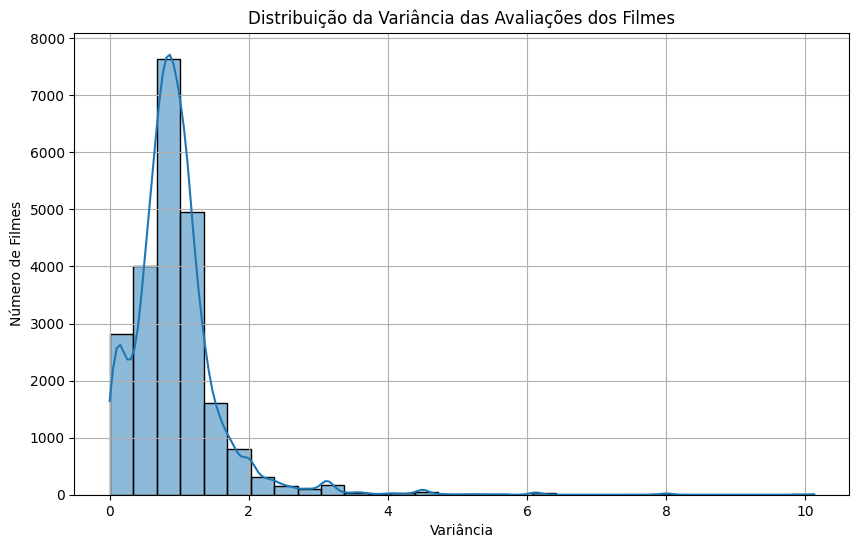

In [7]:
# Calculo da variância das avaliações

film_variance = df_movie_rating.groupby('movieId')['rating'].var().reset_index()
film_variance.columns = ['movieId', 'variance']


plt.figure(figsize=(10, 6))
sns.histplot(film_variance['variance'], bins=30, kde=True)
plt.title('Distribuição da Variância das Avaliações dos Filmes')
plt.xlabel('Variância')
plt.ylabel('Número de Filmes')
plt.grid(True)
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-42-86190eb6f3c7>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='title', y='average_rating', data=top_50_movies_with_titles, palette='viridis')


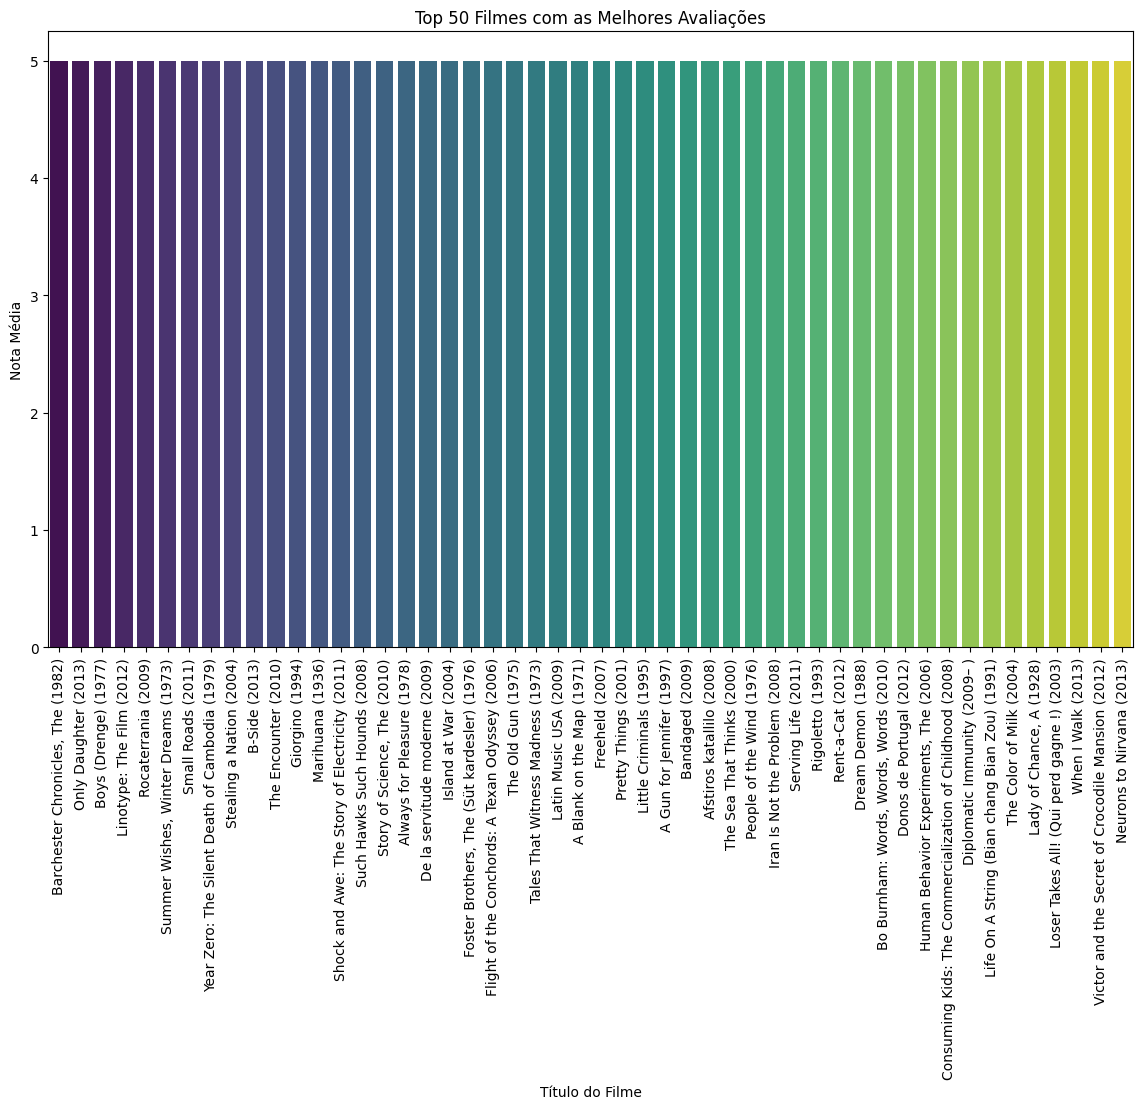

In [ ]:
# Top 50 filmes mais bem avaliados

movie_ratings = df_movie_rating.groupby('movieId')['rating'].mean().reset_index()
movie_ratings.columns = ['movieId', 'average_rating']

top_50_movies = movie_ratings.sort_values(by='average_rating', ascending=False).head(50)
top_50_movies_with_titles = pd.merge(top_50_movies, df_movie[['movieId', 'title']], on='movieId')


plt.figure(figsize=(14, 8))
sns.barplot(x='title', y='average_rating', data=top_50_movies_with_titles, palette='viridis')

plt.title('Top 50 Filmes com as Melhores Avaliações')
plt.xlabel('Título do Filme')
plt.ylabel('Nota Média')
plt.xticks(rotation=90)

plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-31-226c54a33c7a>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='title', y='average_rating', data=worst_50_movies_with_titles, palette='viridis')


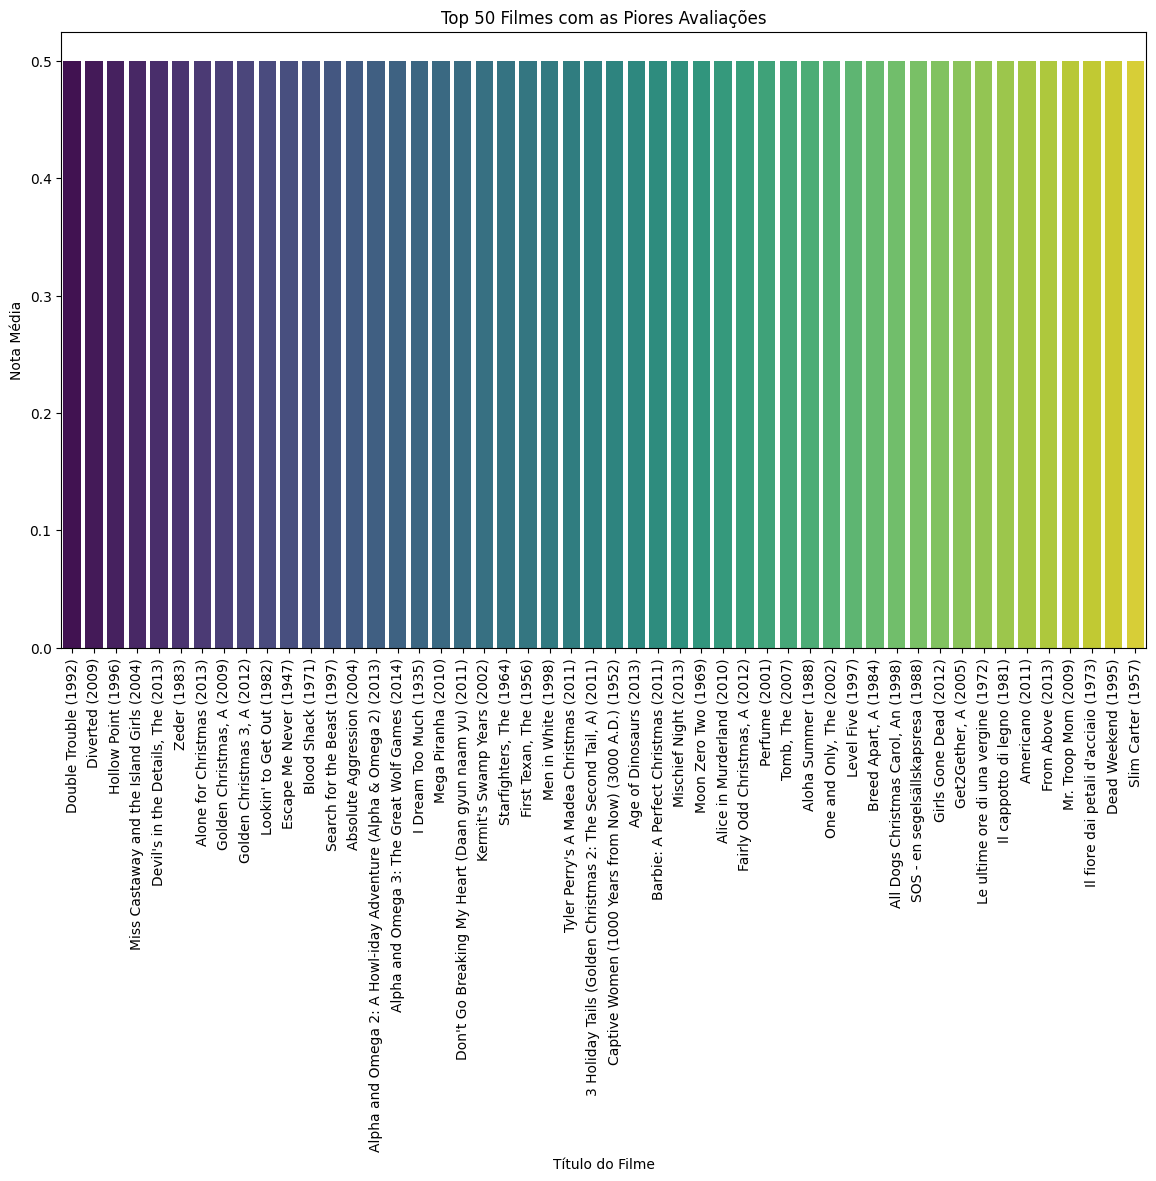

In [ ]:
# Top 50 filmes menos bem avaliados

movie_ratings = df_movie_rating.groupby('movieId')['rating'].mean().reset_index()
movie_ratings.columns = ['movieId', 'average_rating']

worst_50_movies = movie_ratings.sort_values(by='average_rating', ascending=True).head(50)
worst_50_movies_with_titles = pd.merge(worst_50_movies, df_movie[['movieId', 'title']], on='movieId')


plt.figure(figsize=(14, 8))
sns.barplot(x='title', y='average_rating', data=worst_50_movies_with_titles, palette='viridis')

plt.title('Top 50 Filmes com as Piores Avaliações')
plt.xlabel('Título do Filme')
plt.ylabel('Nota Média')
plt.xticks(rotation=90)

plt.show()

Pudemos ver que tem bastante filmes com avaliações boas, mas também muitos com avaliações bem ruins, então seguimos para a diminuição do dataset.


In [5]:
# Filtro na rating.csv, levando em consideração filmes com poucas avaliações e também com uma alta variância nas mesmas

min_ratings_count = 20
max_variance = 1.0

# Poucas avaliações
film_counts = df_movie_rating['movieId'].value_counts().reset_index()
film_counts.columns = ['movieId', 'count']
valid_movies = film_counts[film_counts['count'] >= min_ratings_count]['movieId']

# Alta variância
df_movie_rating_filtered = df_movie_rating[df_movie_rating['movieId'].isin(valid_movies)]
film_variance = df_movie_rating_filtered.groupby('movieId')['rating'].var().reset_index()
film_variance.columns = ['movieId', 'variance']
valid_movies_variance = film_variance[film_variance['variance'] <= max_variance]['movieId']

deleted_movies_by_reviews = set(film_counts[film_counts['count'] < min_ratings_count]['movieId'])
deleted_movies_by_variance = set(film_variance[film_variance['variance'] > max_variance]['movieId'])
deleted_movies = deleted_movies_by_reviews.union(deleted_movies_by_variance)

df_movie_rating_filtered = df_movie_rating[~df_movie_rating['movieId'].isin(deleted_movies)]
df_movie_filtered = df_movie[~df_movie['movieId'].isin(deleted_movies)]

print(f"Quantidade de avaliações antes da exclusão: {len(df_movie_rating)}")
print(f"Quantidade de avaliações após a exclusão: {len(df_movie_rating_filtered)}")
print(f"Quantidade de filmes antes da exclusão: {len(df_movie)}")
print(f"Quantidade de filmes após a exclusão: {len(df_movie_filtered)}")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Quantidade de avaliações antes da exclusão: 20000263
Quantidade de avaliações após a exclusão: 15061821
Quantidade de filmes antes da exclusão: 27278
Quantidade de filmes após a exclusão: 8450


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-8-30da35275873>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_movie_rating_filtered['rating'] = np.floor(df_movie_rating_filtered['rating'])
<ipython-input-8-30da35275873>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='rat

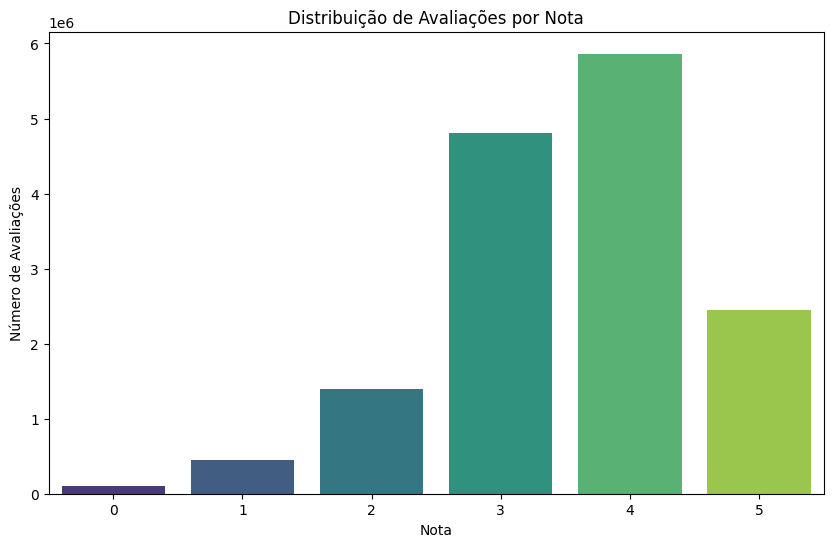

In [8]:
# Contar o número de avaliações para cada nota
rating_counts = df_movie_rating_filtered['rating'].value_counts().sort_index().reset_index()
rating_counts.columns = ['rating', 'count']

# Arredondar todas as notas para baixo
df_movie_rating_filtered['rating'] = np.floor(df_movie_rating_filtered['rating'])

rating_counts = df_movie_rating_filtered['rating'].value_counts().sort_index()

# Garantir que todas as notas de 0 a 5 estejam presentes
valid_ratings = [0, 1, 2, 3, 4, 5]
rating_counts = rating_counts.reindex(valid_ratings, fill_value=0).reset_index()

# Crie o gráfico
plt.figure(figsize=(10, 6))
sns.barplot(x='rating', y='count', data=rating_counts, palette='viridis')

# Adicione títulos e rótulos
plt.title('Distribuição de Avaliações por Nota')
plt.xlabel('Nota')
plt.ylabel('Número de Avaliações')

# Exiba o gráfico
plt.show()

Sobre as avaliações, vimos que estão bem distribuídas, com sua maioria entre notas 3-4. Portanto, foi decidido que nada seria feito com relação a elas diretamente, já que o algoritmo utilizado não necessitaria delas.<br/><br/>

Aqui é o começo da dinâmica do código de Apriori para a Regra de Associação, com interação de um usuário externo e novo.
<br/><br/>
A sequência de ações é:<br/>
<br/>1. Perguntar a um usuário se ele deseja receber a recomendação focada em um gênero específico ou se tanto faz;
<br/>2. Filtrar (ou não) a base de rating, para que ela fique direcionada ao que o usuário gostaria;
<br/>3. Inserir alguns filmes que o usuário escolheu na base de rating;
<br/>4. Fazer a recomendação baseada nos inputs novos do usuário.

In [ ]:
# Extraindo todos os gêneros

genres_series = df_movie_filtered['genres'].str.split('|', expand=True).stack().unique()

print("Categorias de filmes no df_movie_filtered:")
for genre in sorted(genres_series):
    print(genre)


In [6]:
print("Escolha o tipo de recomendação:")
print("0 - Recomendação padrão (sem filtro de gênero)")
print("1  - Ação")
print("2  - Aventura")
print("3  - Animação")
print("4  - Crianças")
print("5  - Comédia")
print("6  - Crime")
print("7  - Documentário")
print("8  - Drama")
print("9  - Fantasia")
print("10 - Noir")
print("11 - Horror")
print("12 - IMAX")
print("13 - Musical")
print("14 - Mistério")
print("15 - Romance")
print("16 - Sci-Fi")
print("17 - Suspense")
print("18 - Guerra")
print("19 - Western")

genre_code = int(input("Digite o código do gênero: "))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Escolha o tipo de recomendação:
0 - Recomendação padrão (sem filtro de gênero)
1  - Ação
2  - Aventura
3  - Animação
4  - Crianças
5  - Comédia
6  - Crime
7  - Documentário
8  - Drama
9  - Fantasia
10 - Noir
11 - Horror
12 - IMAX
13 - Musical
14 - Mistério
15 - Romance
16 - Sci-Fi
17 - Suspense
18 - Guerra
19 - Western
Digite o código do gênero: 2


In [ ]:
if genre_code != 0:
    genres = {1: 'Action', 2: 'Adventure', 3: 'Animation', 4: 'Children', 5: 'Comedy', 6: 'Crime',
              7: 'Documentary', 8: 'Drama', 9: 'Fantasy', 10: 'Film-Noir', 11: 'Horror', 12: 'IMAX', 13: 'Musical',
              14: 'Mystery', 15: 'Romance', 16: 'Sci-Fi', 17: 'Thriller', 18: 'War', 19: 'Western'}
    genre = genres.get(genre_code, None)
    if genre:
        df_movie_filtered = df_movie[df_movie['genres'].str.contains(genre, case=False, na=False)]
        filtered_movie_ids = df_movie_filtered['movieId'].tolist()
        df_movie_rating_filtered = df_movie_rating_filtered[df_movie_rating_filtered['movieId'].isin(filtered_movie_ids)]
        different_movies_count = df_movie_rating_filtered['movieId'].value_counts()
        top_30_movies = different_movies_count.head(30).index.tolist()
        top_movies = df_movie_filtered[df_movie_filtered['movieId'].isin(top_30_movies)]
    else:
        print("Categoria não reconhecida! Fazendo uma recomendação geral...")
else:
    different_movies_count = df_movie_rating_filtered['movieId'].value_counts()
    top_30_movies = different_movies_count.head(30).index.tolist()
    top_movies = df_movie_filtered[df_movie_filtered['movieId'].isin(top_30_movies)]


print('*** FILMES ***\n')
print('ID     NOME')
print('-------------------------------------------------')

for index, row in top_movies.iterrows():
  if 0 <= row['movieId'] < 10:
    print(f"{row['movieId']}      {row['title']}")
  elif 10 <= row['movieId'] < 100:
    print(f"{row['movieId']}     {row['title']}")
  elif 100 <= row['movieId'] < 1000:
    print(f"{row['movieId']}    {row['title']}")
  elif 1000 <= row['movieId'] < 10000:
    print(f"{row['movieId']}   {row['title']}")
  elif 10000 <= row['movieId'] < 100000:
    print(f"{row['movieId']}  {row['title']}")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


*** FILMES ***

ID     NOME
-------------------------------------------------
1      Toy Story (1995)
10     GoldenEye (1995)
150    Apollo 13 (1995)
153    Batman Forever (1995)
260    Star Wars: Episode IV - A New Hope (1977)
316    Stargate (1994)
329    Star Trek: Generations (1994)
364    Lion King, The (1994)
380    True Lies (1994)
480    Jurassic Park (1993)
588    Aladdin (1992)
590    Dances with Wolves (1990)
648    Mission: Impossible (1996)
733    Rock, The (1996)
1136   Monty Python and the Holy Grail (1975)
1196   Star Wars: Episode V - The Empire Strikes Back (1980)
1197   Princess Bride, The (1987)
1198   Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)
1200   Aliens (1986)
1210   Star Wars: Episode VI - Return of the Jedi (1983)
1270   Back to the Future (1985)
1291   Indiana Jones and the Last Crusade (1989)
1527   Fifth Element, The (1997)
3578   Gladiator (2000)
3793   X-Men (2000)
4306   Shrek (2001)
4993   Lord of the Rings: The Fell

In [ ]:
# Adicionando o novo usuário e suas avaliações no rating.csv

new_ratings = pd.DataFrame([
    {'userId': 138494, 'movieId': 260, 'rating': 4},  # 2 poucos
    {'userId': 138494, 'movieId': 329, 'rating': 4},  # The Godfather
    {'userId': 138494, 'movieId': 1210, 'rating': 4}, # The Matrix
    {'userId': 138494, 'movieId': 7153, 'rating': 4},  # Jurassic Park
    {'userId': 138494, 'movieId': 1270, 'rating': 4},  # Jurassic Park
])

df_movie_rating_filtered = pd.concat([df_movie_rating_filtered, new_ratings], ignore_index=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Agrupando os filmes por userId
user_movies = df_movie_rating_filtered.groupby('userId')['movieId'].apply(list).tolist()

# Aplicando o TransactionEncoder
te = TransactionEncoder()
te_ary = te.fit(user_movies).transform(user_movies)
df_transactions = pd.DataFrame(te_ary, columns=te.columns_)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Apriori
# frequent_itemsets = apriori(user_movie_binary_matrix, min_support=0.18, use_colnames=True)
frequent_itemsets = apriori(df_transactions, min_support=0.18, use_colnames=True)

# Regras de associação
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=3)

# Regras ordenadas pelo lift
rules = rules.sort_values(by="lift", ascending=False)
print(rules.head(20))


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


     antecedents   consequents  antecedent support  consequent support  \
10        (7153)  (5952, 4993)            0.230746            0.219968   
7   (5952, 4993)        (7153)            0.219968            0.230746   
8   (7153, 4993)        (5952)            0.205470            0.248056   
9         (5952)  (7153, 4993)            0.248056            0.205470   
4         (5952)        (7153)            0.248056            0.230746   
5         (7153)        (5952)            0.230746            0.248056   
11        (4993)  (5952, 7153)            0.274406            0.200604   
6   (5952, 7153)        (4993)            0.200604            0.274406   
2         (7153)        (4993)            0.230746            0.274406   
3         (4993)        (7153)            0.274406            0.230746   
1         (4993)        (5952)            0.274406            0.248056   
0         (5952)        (4993)            0.248056            0.274406   
16  (1210, 1196)   (260, 1270)        

In [ ]:
# Recomendação final
user_watched_movies = set(new_ratings['movieId'].tolist())

# Filtrar regras onde o antecedente inclui filmes que o usuário assistiu
recommended_movies = set()
for _, row in rules.iterrows():
    if any(movie in user_watched_movies for movie in row['antecedents']):
        recommended_movies.update(row['consequents'])

recommended_movies.difference_update(user_watched_movies)

# Mostrar os filmes recomendados
recommended_movies_with_titles = df_movie[df_movie['movieId'].isin(recommended_movies)]
print("Filmes recomendados para o usuário 138494:")
print(recommended_movies_with_titles[['movieId', 'title']])

Filmes recomendados para o usuário 138494:
      movieId                                              title
476       480                               Jurassic Park (1993)
1171     1196  Star Wars: Episode V - The Empire Strikes Back...
1173     1198  Raiders of the Lost Ark (Indiana Jones and the...
4897     4993  Lord of the Rings: The Fellowship of the Ring,...
5853     5952      Lord of the Rings: The Two Towers, The (2002)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
